<a href="https://colab.research.google.com/github/Nannanpeng/Treaty_Game/blob/master/Treaty_game_data_simulation_treaty_length.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Data simulation for treaty game
## <center> ---- model for treaty length
## There are several conclusions from this simlutaion.
* Assuming that treaty lengh follows a geometric distribution. Both geometric and exponential model can help recover the ture parameter and detect the treatment effects.
* If there are heterogeneities in a treatment, geometric and exponential model can still detect the treatment effects but not the true parameters.
* A poisson model does not work well in both cases.
* A mixture model is not a good choice for this simulated data for two reasons. There are just 200 simulated data points for each treatment. Also, the difference between the two treatments is not that big (just 0.05) or the data is very close to each other in the two treatments. If the two problems can be solved. A mixture model might work well. PS: I have played with different parameters and found this. There are also some hints in this post https://mc-stan.org/users/documentation/case-studies/identifying_mixture_models.html.
* Based on what I did, I think we need at least 150-200 data points for each treatment if we want our analysis to work. 

In [ ]:
!pip install --upgrade pymc3==3.8
!pip install arviz

     |████████████████████████████████| 911kB 2.8MB/s 
     |████████████████████████████████| 1.5MB 46.3MB/s 
     |████████████████████████████████| 4.1MB 32.6MB/s 
     |████████████████████████████████| 327kB 42.1MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [ ]:
from scipy.stats import geom, norm
from scipy.special import expit
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc3.distributions.transforms as tr
import theano.tensor as tt

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [ ]:
np.random.seed(12345) 

## Data generation
1). Pure distribution

In [ ]:
n = 200   # number of data points for each treatment
prob_annuity_ending = 0.2
prob_lumpsum_ending = 0.15
noises = norm.rvs(0, 0.001, size=n)

annuity_treaty_length = geom.rvs(prob_annuity_ending + noises)
lumpsum_treaty_length = geom.rvs(prob_lumpsum_ending + noises)
treaty_len = np.concatenate((annuity_treaty_length, lumpsum_treaty_length))
institute = [1]*n + [0]*n

pure_sim_data = pd.DataFrame(zip(treaty_len, institute), columns=['TreatyLength', 'Institute'])

In [ ]:
pure_sim_data

,TreatyLength,Institute
0,18,1
1,12,1
2,2,1
3,16,1
4,3,1
...,...,...
395,1,0
396,12,0
397,5,0
398,2,0


2). Mixture distribution

In [ ]:
n = 200   # number of data points for each treatment
prob_annuity_ending_1, prob_annuity_ending_2 = 0.3, 0.1
prob_lumpsum_ending_1, prob_lumpsum_ending_2 = 0.25, 0.05

noises = norm.rvs(0, 0.001, size=n//2)
annuity_prob = list(prob_annuity_ending_1 + noises) + list(prob_annuity_ending_2 + noises)
annuity_treaty_length = geom.rvs(annuity_prob)

lumpsum_prob = list(prob_lumpsum_ending_1 + noises) + list(prob_lumpsum_ending_2 + noises)
lumpsum_treaty_length = geom.rvs(lumpsum_prob)

treaty_len = np.concatenate((annuity_treaty_length, lumpsum_treaty_length))
institute = [1]*n + [0]*n

mix_sim_data = pd.DataFrame(zip(treaty_len, institute), columns=['TreatyLength', 'Institute'])

In [ ]:
mix_sim_data

,TreatyLength,Institute
0,7,1
1,4,1
2,1,1
3,3,1
4,1,1
...,...,...
395,9,0
396,2,0
397,42,0
398,7,0


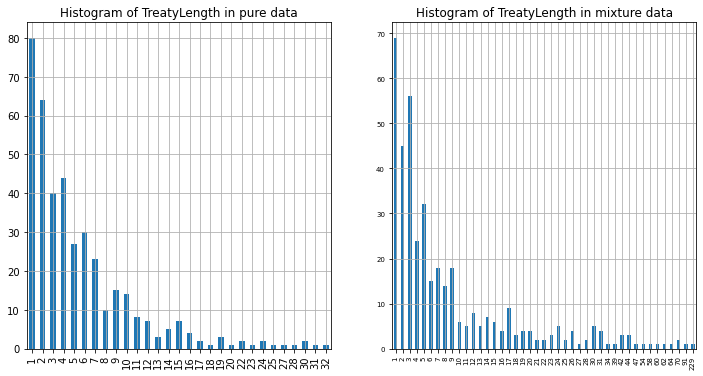

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

pure = pure_sim_data['TreatyLength'].value_counts().sort_index()
pure.plot(kind='bar', title='Histogram of TreatyLength in pure data', grid=True, ax=ax1, fontsize=10)

mix = mix_sim_data['TreatyLength'].value_counts().sort_index()
mix.plot(kind='bar', title='Histogram of TreatyLength in mixture data', grid=True, ax=ax2, fontsize=7);

## Simulation (Pymc 3)

## 1). Geometric model
A. Pure data

In [ ]:
def GeometricModel(data):
  with pm.Model() as model:
      betas = pm.Normal('betas', 0, 20, shape=2)
      p = 1/(1 + np.exp(-(betas[0] + betas[1] * data['Institute'])))
      obs = pm.Geometric('obs', p, observed=data['TreatyLength'])
      trace = pm.sample(2000, tune=1000, chains=2, cores=2)    
  return trace, model

In [ ]:
trace_1, model_1 = GeometricModel(pure_sim_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:08<00:00, 702.15draws/s]


In [ ]:
res1 = pm.summary(trace_1)
res1

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],-1.719,0.080,-1.864,-1.566,0.002,0.001,1582.0,1575.0,1587.0,1836.0,1.0
betas[1],0.435,0.112,0.238,0.649,0.003,0.002,1425.0,1410.0,1430.0,1966.0,1.0


In [ ]:
print('The geometric probability for lump_sum is: {:.3f}.'.format(expit(res1.iloc[0,0])))
print('The geometric probability for annuity is: {:.3f}.'.format(expit(res1.iloc[0,0] + res1.iloc[1,0])))

The geometric probability for lump_sum is: 0.152.
The geometric probability for annuity is: 0.217.


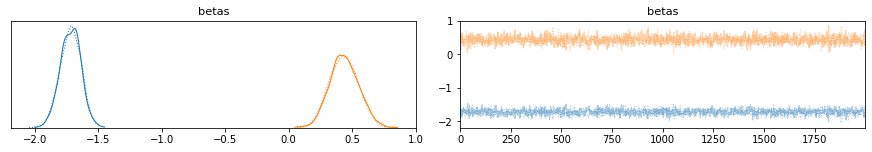

In [ ]:
pm.traceplot(trace_1);

The geometric model fits the data well. It can correctly recover the parameters.


B. Mixture data

In [ ]:
trace_1_mix, model_1_mix = GeometricModel(mix_sim_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:08<00:00, 725.98draws/s]


In [ ]:
res1_mix = pm.summary(trace_1_mix)
res1_mix

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],-2.440,0.074,-2.591,-2.311,0.002,0.002,1215.0,1212.0,1215.0,1809.0,1.0
betas[1],0.652,0.108,0.460,0.861,0.003,0.002,1496.0,1469.0,1483.0,1804.0,1.0


In [ ]:
print('The geometric probability for lump_sum is: {:.3f}.'.format(expit(res1_mix.iloc[0,0])))
print('The geometric probability for annuity is: {:.3f}.'.format(expit(res1_mix.iloc[0,0] + res1_mix.iloc[1,0])))

The geometric probability for lump_sum is: 0.080.
The geometric probability for annuity is: 0.143.


For mixture data, the geometric model can still figure out the treatment effects.

## 2). Exponential model
A. Pure data

In [ ]:
def ExponentialModel(data):
   with pm.Model() as model:
      betas = pm.Uniform('betas', 0, 5, shape=2)
      lam = betas[0] + betas[1] * data['Institute']
      obs = pm.Exponential('obs', lam, observed=data['TreatyLength'])
      trace = pm.sample(2000, tune=1000, chains=2, cores=2)    
   return trace, model

In [ ]:
trace_2, model_2 = ExponentialModel(pure_sim_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:05<00:00, 1027.45draws/s]


In [ ]:
pm.summary(trace_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],0.153,0.012,0.131,0.175,0.000,0.0,1226.0,1226.0,1220.0,1257.0,1.0
betas[1],0.065,0.020,0.028,0.100,0.001,0.0,1363.0,1363.0,1352.0,1371.0,1.0


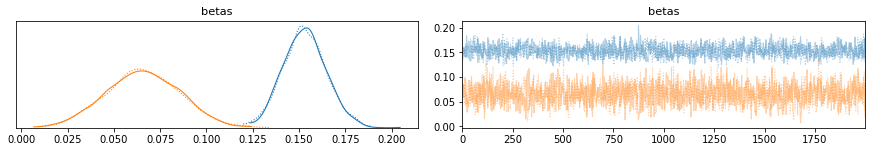

In [ ]:
pm.traceplot(trace_2);

The exponential model fits the pure data well, though the data is generated through a geometric process.

B. Mixture data

In [ ]:
trace_2_mix, model_2_mix = ExponentialModel(mix_sim_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:05<00:00, 1033.92draws/s]


In [ ]:
pm.summary(trace_2_mix)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],0.081,0.006,0.070,0.092,0.0,0.0,1907.0,1907.0,1898.0,1576.0,1.0
betas[1],0.063,0.012,0.042,0.086,0.0,0.0,2193.0,2193.0,2186.0,2297.0,1.0


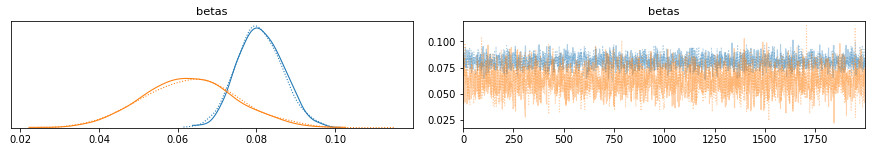

In [ ]:
pm.traceplot(trace_2_mix);

For mixture data, the exponential model can detect the treatment effects as well.

## 3). Poisson model
A. Pure data

In [ ]:
def PoissonModel(data):
   with pm.Model() as model:
      betas = pm.Uniform('betas', 0, 5, shape=2)
      lam = betas[0] + betas[1] * data['Institute']
      obs = pm.Poisson('obs', lam, observed=data['TreatyLength'])
      trace = pm.sample(2000, tune=1000, chains=2, cores=2)    
   return trace, model

In [ ]:
trace_3, model_3 = PoissonModel(pure_sim_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]
Sampling 2 chains, 1 divergences: 100%|██████████| 6000/6000 [00:06<00:00, 934.41draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [ ]:
pm.summary(trace_3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],4.979,0.021,4.941,5.000,0.000,0.000,1975.0,1971.0,1386.0,1146.0,1.0
betas[1],0.055,0.050,0.000,0.146,0.001,0.001,2484.0,2484.0,1860.0,1268.0,1.0


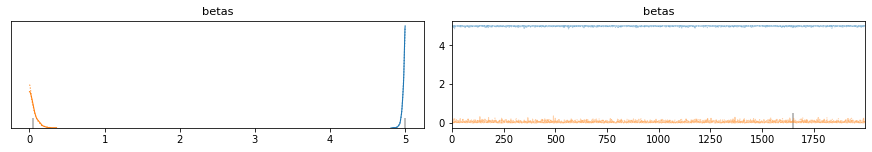

In [ ]:
pm.traceplot(trace_3);

The model fit is not vert good and it is hard to see the treatment effects.

B. Mixture data

In [ ]:
trace_3_mix, model_3_mix = PoissonModel(mix_sim_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]
Sampling 2 chains, 2 divergences: 100%|██████████| 6000/6000 [00:05<00:00, 1081.16draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
pm.summary(trace_3_mix)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],4.997,0.004,4.990,5.000,0.000,0.000,3030.0,3029.0,2033.0,1681.0,1.0
betas[1],1.996,0.186,1.637,2.336,0.004,0.002,2794.0,2788.0,2787.0,2365.0,1.0


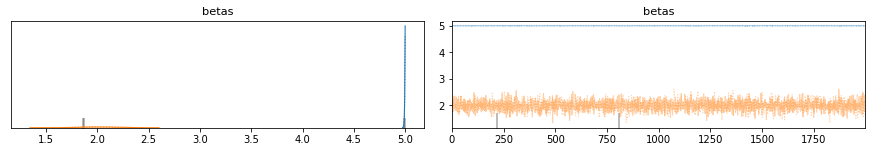

In [ ]:
pm.traceplot(trace_3_mix);

For the mixture data, a poisson model can detect the treatment effects.

## 4). Mixture model

In [ ]:
def MixtureModel(data):
    with pm.Model() as model:
        betas = pm.Normal('betas', 0, 10, shape=2, transform=tr.ordered, testval=[0.1, 0.5])
        prob_0 = 1/(1 + np.exp(-betas[0]))
        prob_1 = 1/(1 + np.exp(-betas[1]))
        geo_0 = pm.Geometric.dist(prob_0)
        geo_1 = pm.Geometric.dist(prob_1)
        w = pm.Dirichlet('weights', a=np.array([1, 1]))
        like = pm.Mixture('like', w=w, comp_dists = [geo_0, geo_1], observed=data['TreatyLength'])
        trace = pm.sample(4000, tune=1000, chains=2, cores=1)
    return trace, model

In [ ]:
trace_4, model_4 = MixtureModel(pure_sim_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [weights, betas]
Sampling chain 1, 39 divergences: 100%|██████████| 5000/5000 [00:22<00:00, 218.73it/s]
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7106120620857695, but should be close to 0.8. Try to increase the number of tuning steps.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6954145003977417, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
res_2 = pm.summary(trace_4)
res_2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
betas[0],-1.659,0.129,-1.913,-1.456,0.009,0.006,229.0,215.0,283.0,158.0,1.0
betas[1],1.892,5.232,-1.625,13.068,0.164,0.116,1018.0,1018.0,760.0,1915.0,1.0
weights[0],0.747,0.235,0.307,1.000,0.011,0.008,481.0,430.0,582.0,1357.0,1.0
weights[1],0.253,0.235,0.000,0.693,0.011,0.008,481.0,481.0,582.0,1357.0,1.0


In [ ]:
print('The probability in the first geometric distribution is: {:.3f}.'.format(1/(1 + np.exp(-res_2.iloc[0,0]))))
print('The probability in the second geometric distribution is: {:.3f}.'.format(1/(1 + np.exp(-res_2.iloc[0,1]))))

The probability in the first geometric distribution is: 0.160.
The probability in the second geometric distribution is: 0.532.


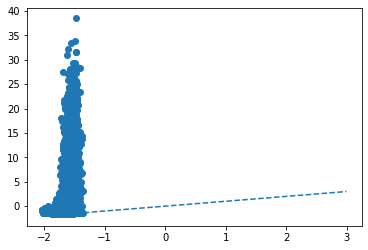

In [ ]:
x = trace_4['betas']  # see the constraint from the samples
plt.scatter(x[:,0], x[:,1])
plt.plot([-2,3],[-2,3], '--');

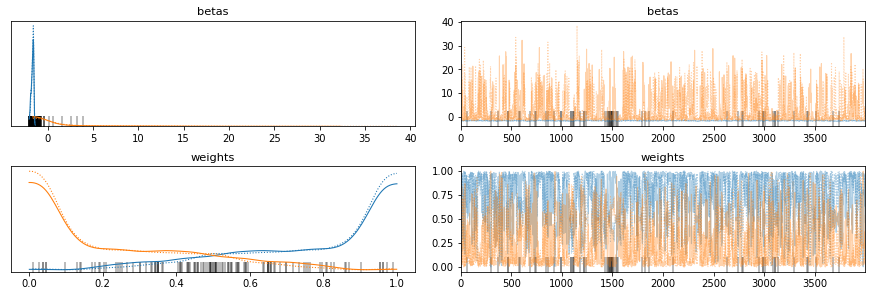

In [ ]:
pm.traceplot(trace_4);

This mixture model does not fit the model well.